In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import networkx as nx
import os
# !pip install h3
import h3
# !pip install h3pandas
import h3pandas
from shapely import wkt

# AGGREGATE POP DENSITY

Hex 8 from Kontur

In [2]:
# read population file
import gzip
with gzip.open(os.path.join('data','kontur_population_GB_20220630.gpkg.gz'), 'rb') as f:
  pop_uk = gpd.read_file(f, driver='GPKG') 

# Load london boundary shapefile
london = ox.geocode_to_gdf('Greater London, UK')
london = london.to_crs(epsg=4326)

# filter for London only
pop_uk.to_crs(epsg=4326, inplace=True)
pop_london = pop_uk[pop_uk.geometry.intersects(london.geometry[0])]
pop_london.set_index('h3', inplace=True)

pop_london.head()

,population,geometry
h3,,
88195d3759fffff,149.0,"POLYGON ((-0.48938 51.50286, -0.49610 51.50164..."
88195d3757fffff,151.0,"POLYGON ((-0.50521 51.49145, -0.51193 51.49023..."
88195d3753fffff,19.0,"POLYGON ((-0.49297 51.48940, -0.49969 51.48818..."
88195d371bfffff,47.0,"POLYGON ((-0.49657 51.47594, -0.50329 51.47472..."
88195d3719fffff,113.0,"POLYGON ((-0.50089 51.48370, -0.50761 51.48248..."


In [3]:
# export to file
pop_london.to_file(os.path.join('data','cleaned','pop_london_h8.geojson'))

OA2HEX

In [4]:
## Load Population by OA (Census 2021)
# Load OA shapefile
oa = gpd.read_file(os.path.join('data','statistical-gis-boundaries-london','ESRI','OA_2011_London_gen_MHW.shp'))
oa.to_crs(epsg=4326, inplace=True)

# Read population data for OA21
oa21_pop_london = pd.read_csv(os.path.join('data','oa_2021_pop_london.csv'))
oa_21 = gpd.read_file(os.path.join('data','oa11tooa21.geojson')) # OA11 -> OA21 conversion
oa['OA21CD'] = oa['OA11CD'].map(oa_21.set_index('OA11CD')['OA21CD'])

# merge population data with OA shapefile
oa_pop_london = oa21_pop_london.merge(oa[['OA21CD','geometry']], left_on='OA21CD', right_on='OA21CD')
oa_pop_london = gpd.GeoDataFrame(oa_pop_london, crs='EPSG:4326', geometry='geometry')

In [32]:
## function to convert OA population gdf to hexagons gdf

def pop_oa2hex(oa_pop, resolution=8):
    # convert OA to hexagons
    h = oa_pop.h3.polyfill(resolution=resolution)
    
    # populate hexagons with population, weighted by area divide the population by the number of hexagons
    # This is to ensure that the population is distributed evenly across the hexagons
    h3_list = []
    pop_list = []

    for i in range(len(h)):
        for h3 in h.h3_polyfill[i]:
            h3_list.append(h3)
            pop_round = round(h.population[i]/len(h.h3_polyfill[i]))
            pop_list.append(pop_round)

    h3_pop = pd.DataFrame({'h3': h3_list, 'population': pop_list})
    h3_pop.set_index('h3', inplace=True)

    # filter for invalid hexagons
    h3_pop = h3_pop.h3.h3_is_valid()
    h3_pop = h3_pop[h3_pop.h3_is_valid == True]
    h3_pop.drop(columns=['h3_is_valid'], inplace=True)

    # convert to geodataframe
    h3_pop_gdf = h3_pop.h3.h3_to_geo_boundary()

    return h3_pop_gdf   


In [34]:
pop_hex10 = pop_oa2hex(oa_pop_london, 10)
pop_hex10.head()

,population,geometry
h3,,
8a194ad362c7fff,259,"POLYGON ((-0.09582 51.52045, -0.09678 51.52028..."
8a194ad3294ffff,29,"POLYGON ((-0.09687 51.51662, -0.09783 51.51645..."
8a194ad30497fff,29,"POLYGON ((-0.09626 51.51551, -0.09722 51.51534..."
8a194ad32957fff,29,"POLYGON ((-0.09922 51.51802, -0.10018 51.51785..."
8a194ad32967fff,29,"POLYGON ((-0.09634 51.51853, -0.09730 51.51836..."


# AGGREGATE POI DENSITY BY TYPE

PLACES OF WORKSHIP

In [15]:
# Load Places of worship (area), take centroid
gdf_pofw = gpd.read_file(os.path.join('data','osm','greater-london-latest-free.shp','gis_osm_pofw_a_free_1.shp'))
gdf_pofw.to_crs(epsg=27700, inplace=True)
gdf_pofw['geometry'] = gdf_pofw.centroid

# Load Places of worship (point)
gdf_pofw_pt = gpd.read_file(os.path.join('data','osm','greater-london-latest-free.shp','gis_osm_pofw_free_1.shp'))
gdf_pofw_pt.to_crs(epsg=27700, inplace=True)

# Merge two datasets together
gdf_pofw_merged = pd.concat([gdf_pofw, gdf_pofw_pt], ignore_index=True)
gdf_pofw_merged['category']='religious'
gdf_pofw_merged.tail()

,osm_id,code,fclass,name,geometry,category
3096,11479357650,3103,christian_evangelical,UCKG Help Centre,POINT (539092.764 184583.684),religious
3097,11543657111,3300,muslim,Chadwell Heath Muslim Centre,POINT (547336.060 187774.258),religious
3098,11544241893,3100,christian,West Wickham Methodist Church,POINT (538761.375 165985.736),religious
3099,11780635078,3300,muslim,Limehouse Bangladeshi Cultural Centre,POINT (536918.189 180871.930),religious
3100,11780635081,3300,muslim,None,POINT (536935.615 180861.505),religious


Text(0.5, 1.0, 'Places of Worship')

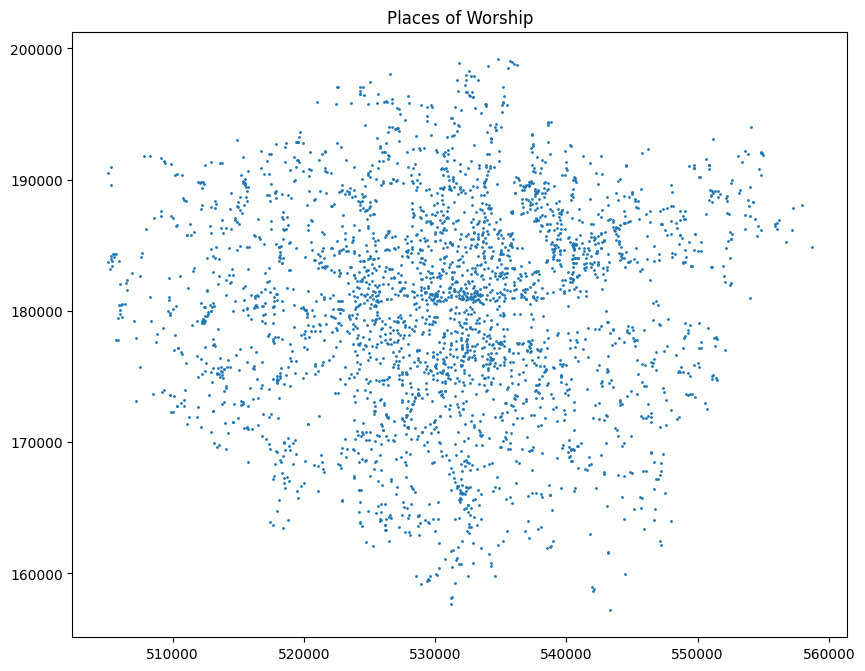

In [99]:
# Plot Places of worship
gdf_pofw_merged.plot(markersize=1, figsize=(10,10),).set_title('Places of Worship')

POINT OF INTEREST

In [16]:
# Load Points of interest (area), take centroid
gdf_poi = gpd.read_file(os.path.join('data','osm','greater-london-latest-free.shp','gis_osm_pois_a_free_1.shp'))
gdf_poi.to_crs(epsg=27700, inplace=True)
gdf_poi['geometry'] = gdf_poi.centroid

# Load Points of interest (point)
gdf_poi_pt = gpd.read_file(os.path.join('data','osm','greater-london-latest-free.shp','gis_osm_pois_free_1.shp'))
gdf_poi_pt.to_crs(epsg=27700, inplace=True)

# Merge two datasets together
gdf_poi_merged = pd.concat([gdf_poi, gdf_poi_pt], ignore_index=True)
gdf_poi_merged.tail()

,osm_id,code,fclass,name,geometry
134864,11871881153,2561,hairdresser,"AB Barbers, Nails & Beauty",POINT (532435.230 177888.268)
134865,11871885714,2301,restaurant,We Are Mixed Blessings,POINT (532429.509 177860.099)
134866,11871901022,2561,hairdresser,Back To Eden,POINT (532419.012 177829.113)
134867,11871927672,2542,bicycle_shop,Community Bike Shop,POINT (531800.451 177392.099)
134868,11871927780,2561,hairdresser,Lugie’s Salon,POINT (532402.866 177793.318)


In [17]:
# add new column, extract first 2 digits of code column
gdf_poi_merged['category_code'] = gdf_poi_merged['code'].astype('string').str[:2]

# add new column, value depends on category column, 20 is restaurant, 25 is culture
poi_dict = {
    '20':'public_facilities',
    '21':'medical',
    '22':'culture_leisure',
    '23':'restaurants',
    '24':'hotels',
    '25':'shopping',
    '26':'banking',
    '27':'tourism',
    '29':'miscellaneous'
    }

gdf_poi_merged['category'] = gdf_poi_merged['category_code'].map(poi_dict)
#drop category code
gdf_poi_merged.drop(columns=['category_code'], inplace=True)


,osm_id,code,fclass,name,geometry,category
134864,11871881153,2561,hairdresser,"AB Barbers, Nails & Beauty",POINT (532435.230 177888.268),shopping
134865,11871885714,2301,restaurant,We Are Mixed Blessings,POINT (532429.509 177860.099),restaurants
134866,11871901022,2561,hairdresser,Back To Eden,POINT (532419.012 177829.113),shopping
134867,11871927672,2542,bicycle_shop,Community Bike Shop,POINT (531800.451 177392.099),shopping
134868,11871927780,2561,hairdresser,Lugie’s Salon,POINT (532402.866 177793.318),shopping


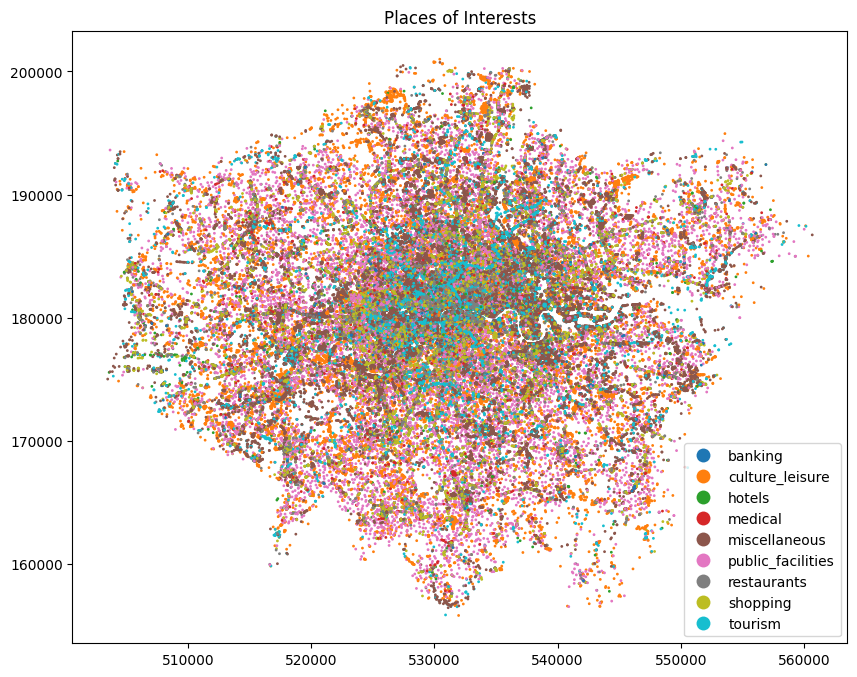

In [18]:
# Plot
gdf_poi_merged.plot(markersize=1, figsize=(10,10),column='category',legend=True).set_title('Places of Interests')
gdf_poi_merged.tail()

TRANSPORT

In [19]:
transport_list =['bus_station','railway_station','airport','ferry_terminal','airfield','taxi','helipad']

In [20]:
# load transport
gdf_transport = gpd.read_file(os.path.join('data','osm','greater-london-latest-free.shp','gis_osm_transport_free_1.shp'))
gdf_transport.to_crs(epsg=27700, inplace=True)
gdf_transport = gdf_transport[gdf_transport.fclass.isin(transport_list)]

# load transport (area), take centroids
gdf_transport_a = gpd.read_file(os.path.join('data','osm','greater-london-latest-free.shp','gis_osm_transport_a_free_1.shp'))
gdf_transport_a.to_crs(epsg=27700, inplace=True)
gdf_transport_a['geometry'] = gdf_transport_a.centroid
gdf_transport_a = gdf_transport_a[gdf_transport_a.fclass.isin(transport_list)]

# merge
gdf_transport_merged = pd.concat([gdf_transport, gdf_transport_a], ignore_index=True)
gdf_transport_merged['category']='transport'

,osm_id,code,fclass,name,geometry,category
0,780856,5601,railway_station,Shepherd's Bush Market,POINT (523195.929 180061.918),transport
1,1256794,5601,railway_station,West Drayton,POINT (506148.838 180085.353),transport
2,2013971,5601,railway_station,Finchley Central,POINT (525294.694 190658.045),transport
3,9780241,5601,railway_station,St Mary Cray,POINT (546593.769 168292.601),transport
4,13884199,5601,railway_station,Mill Hill Broadway,POINT (521351.560 191878.778),transport


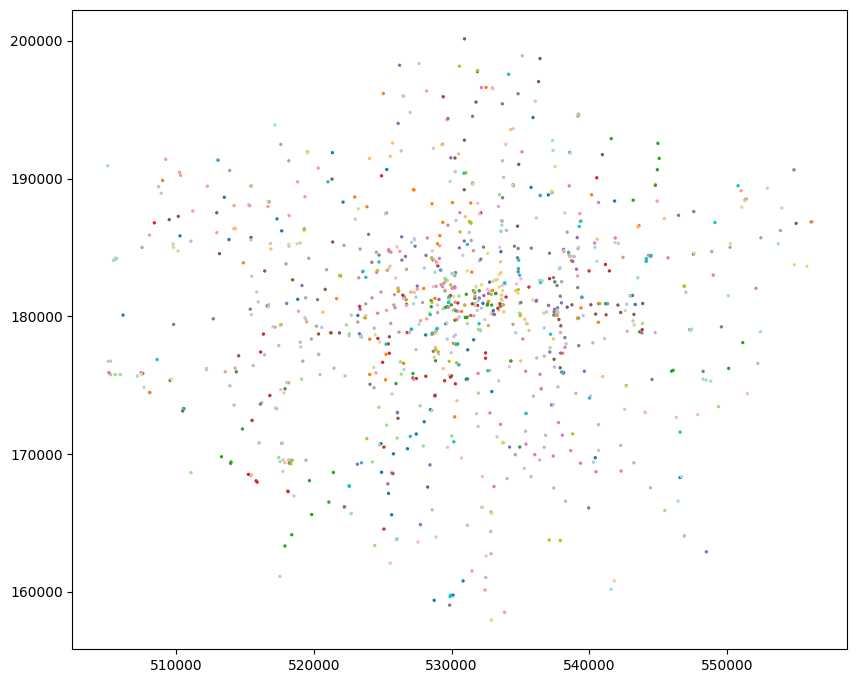

In [22]:
# plot and color by fclass
gdf_transport_merged.plot(markersize=2, figsize=(10,10),legend=True,cmap='tab20')
gdf_transport_merged.head()

MERGE EVERYTHING

Text(0.5, 1.0, 'All Points of Interest')

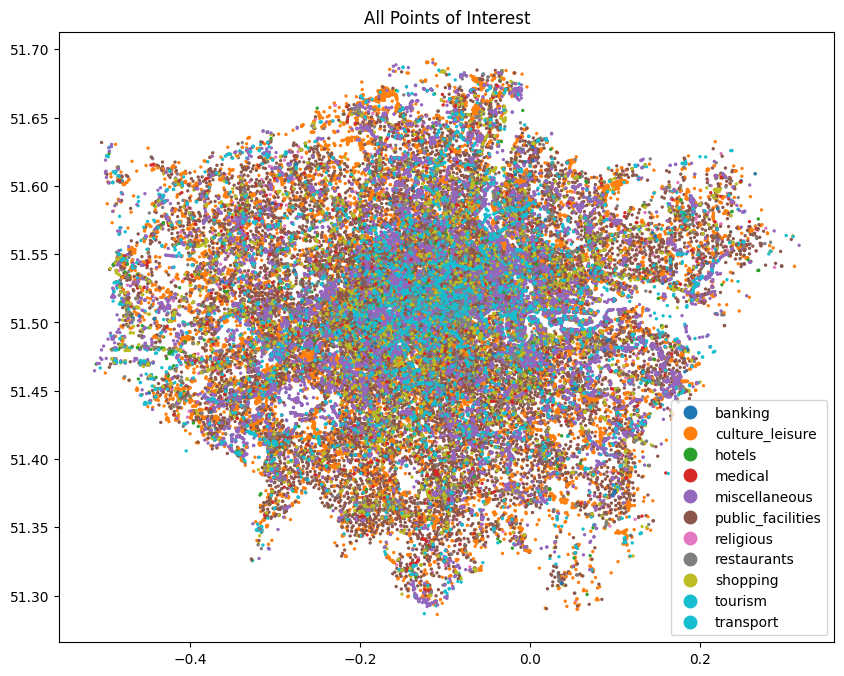

In [26]:
# Merge everything
gdf_poi_all = pd.concat([gdf_pofw_merged, gdf_poi_merged, gdf_transport_merged], ignore_index=True)
gdf_poi_all.to_crs(epsg=4326, inplace=True)
# plot
gdf_poi_all.plot(markersize=2, figsize=(10,10),column='category',legend=True).set_title('All Points of Interest')

In [27]:
gdf_poi_all.tail()

,osm_id,code,fclass,name,geometry,category
138995,1226993763,5641,taxi,None,POINT (-0.01367 51.53350),transport
138996,1226993764,5641,taxi,None,POINT (-0.01447 51.53305),transport
138997,1229484499,5641,taxi,None,POINT (-0.00246 51.54072),transport
138998,1230665737,5655,helipad,Foxtrot Taxiway Helipad,POINT (0.03046 51.32308),transport
138999,1244577739,5655,helipad,None,POINT (0.19402 51.48833),transport


#### AGGREGATE BY H3

In [29]:
# reset index for pop_london
pop_hex10.reset_index(inplace=True)

# Create a geodataframe joining pop_london and gdf_poi_all, aggregate by h3
poi_h3 = gpd.sjoin(gdf_poi_all, pop_hex10, how='inner', predicate='intersects')

# aggregate by h3, count
poi_h3 = poi_h3.groupby(['h3','category']).size().reset_index(name='count')
poi_h3 = poi_h3.pivot(index='h3', columns='category', values='count').fillna(0).reset_index()

# merge with population
poi_pop_h3 = pop_hex10[['h3','geometry','population']].merge(poi_h3, on='h3', how='left').fillna(0)
poi_pop_h3 = gpd.GeoDataFrame(poi_pop_h3, geometry='geometry', crs='EPSG:4326')

poi_pop_h3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 116586 entries, 0 to 116585
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   h3                 116586 non-null  object  
 1   geometry           116586 non-null  geometry
 2   population         116586 non-null  float64 
 3   banking            116586 non-null  float64 
 4   culture_leisure    116586 non-null  float64 
 5   hotels             116586 non-null  float64 
 6   medical            116586 non-null  float64 
 7   miscellaneous      116586 non-null  float64 
 8   public_facilities  116586 non-null  float64 
 9   religious          116586 non-null  float64 
 10  restaurants        116586 non-null  float64 
 11  shopping           116586 non-null  float64 
 12  tourism            116586 non-null  float64 
 13  transport          116586 non-null  float64 
dtypes: float64(12), geometry(1), object(1)
memory usage: 12.5+ MB


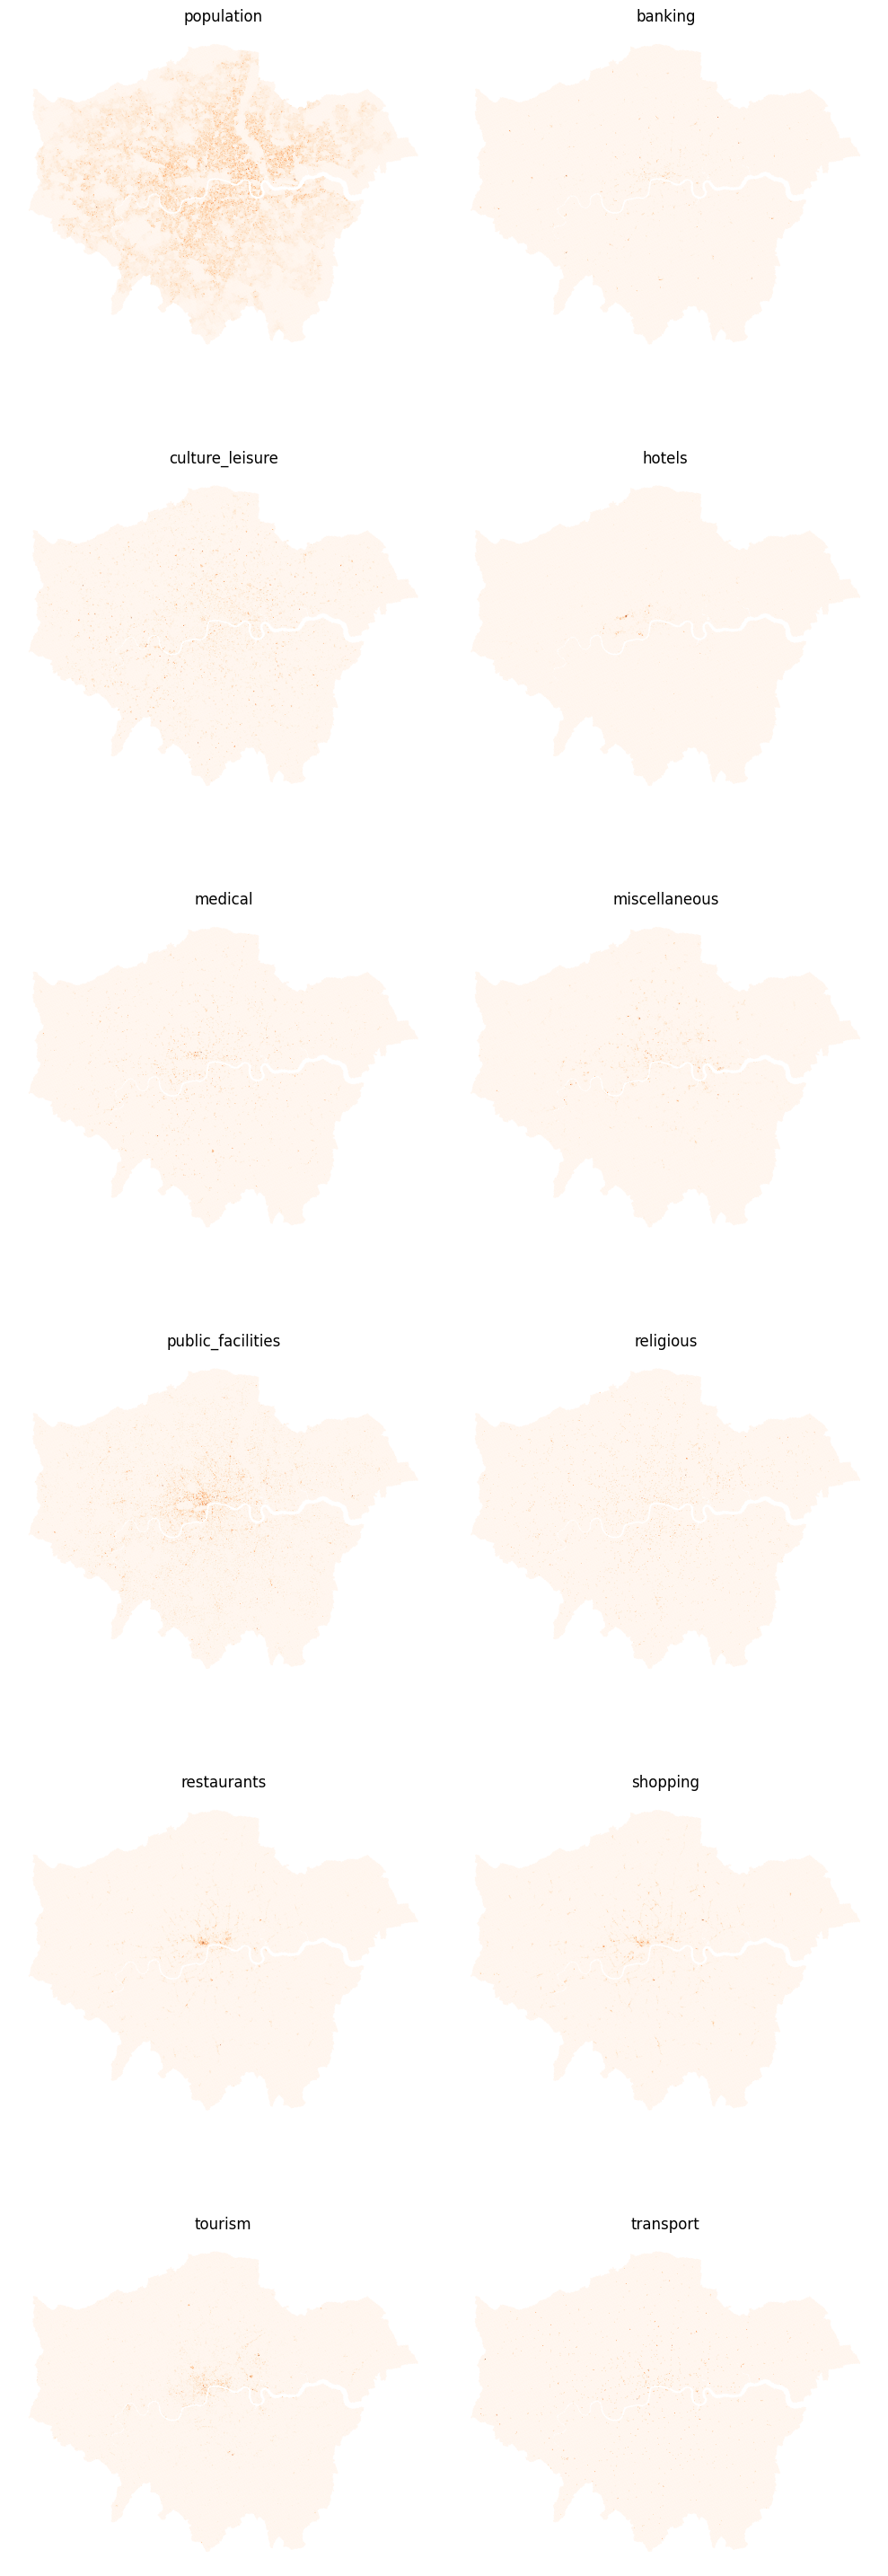

In [36]:
#loop through categories and plot

import matplotlib.pyplot as plt
fig, axs = plt.subplots(6, 2, figsize=(10, 30))
for i, category in enumerate(poi_pop_h3.columns[2:]):
    ax = axs[i//2, i%2]
    poi_pop_h3.plot(column=category, ax=ax, legend=False, cmap='Oranges')
    ax.set_title(category)
    ax.axis('off')
plt.tight_layout()
plt.show()

# EXPORT

In [38]:
#export to geojson
poi_pop_h3.to_crs(epsg=27700, inplace=True)
poi_pop_h3.to_file(os.path.join('data','cleaned','poi_pop_h3_r10.geojson'), driver='GeoJSON')